# MU4MA077, Base d'analyse de donnée, 2024-2025
# Clustering Hierachique et K-Means

<div style="text-align: right"> 
Sorbonne Université, Master 1
</div>

<div style="text-align: right"> 
Merci à Gilles Gallo et aux autres collègues dont j'ai pu m'inspirer pour construire ce TP
</div>

# Table of contents
1. [Le Clustering Hierachique](#part1)
    - [Calculs de distances entre points](#part1sec1)
    - [Distances entre ensembles](#part1sec2)
    - [Implementation du clustering hiérachique](#part1sec3)
    - [Application du clustering avec scipy](#part1sec4)
2. [La méthode du K-means](#part2)
    - [Première utilisation du K-means et selection du K](#part2sec1)
    - [Application à la segmentation d'image](#part2sec2)
3. [Quelques exercices](#part3)
    - [Exercice 1](#part3sec1)
    - [Exercice 2](#part3sec2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.datasets import make_blobs
import scipy.io as sio
from matplotlib.patches import Rectangle

## Le Clustering Hierachique <a id="part1"></a>

Dans cette section, nous allons mettre en pratique le regroupement hiérarchique en utilisant les palettes de définitions de distances que nous avons vues en classe. Tout d'abord, nous allons prendre le temps de revoir la notion de distance entre des points et entre des ensembles de points. Pour illustrer notre démarche, nous prendrons le jeu de données **notes_ACP.txt** contenant les notes de plusieurs étudiants dans quatre matières : Français, Anglais, Mathématiques et Physique.

In [ ]:
# Chargement des données
notes = pd.read_csv('notes_ACP.txt', sep=' ')

# Ajout d'un elève pour l'exercice
newstudent= {"MATH":6.0, "PHYS":6.0, "FRAN":5.0, "ANGL":16.5}
newstudent = pd.DataFrame(newstudent, index=['donald'])
notes= pd.concat([notes,newstudent])

# Aperçu des données
print(notes) 

        MATH  PHYS  FRAN  ANGL
jean     6.0   6.0   5.0   5.5
alan     8.0   8.0   8.0   8.0
anni     6.0   7.0  11.0   9.5
moni    14.5  14.5  15.5  15.0
didi    14.0  14.0  12.0  12.5
andr    11.0  10.0   5.5   7.0
pier     5.5   7.0  14.0  11.5
brig    13.0  12.5   8.5   9.5
evel     9.0   9.5  12.5  12.0
donald   6.0   6.0   5.0  16.5


### Calculs de distances entre points <a id="part1sec1"></a>

On rappel les distances entre points vus en cours: 

- Distance cosinus (angulaire): $\text{dist}(z,\tilde{z}) = \langle z, \tilde{z} \rangle / \Vert z \Vert \Vert \tilde{z} \Vert  $
  
- Distance de Manhattan (ou $\ell_1$): $\text{dist}(z,\tilde{z}) = \sum _{j=1}^{d}|z^{(j)}-\tilde{z}^{(j)}| $
  
- Distance euclidienne  (ou $\ell_2$): $\text{dist}(z,\tilde{z}) = \sqrt{\sum _{j=1}^{d} \left(z^{(j)}-\tilde{z}^{(j)}\right)^2}$
  
- Distance de Tchebychev (ou $\ell_\infty$):  $\text{dist}(z,\tilde{z}) = \max\limits_{j \in [d]} \vert z^{(j)}-\tilde{z}^{(j)} \vert$

- Distance discrète:  $\text{dist}(z, \tilde{z}) = 1\hspace{-3pt}1\left( z \neq \tilde{z}\right) $
  
- Distance de Hamming: $\text{dist}(z, \tilde{z}) = \sum\limits_{j = 1}^{d} 1\hspace{-3pt}1\left( z^{(j)} \neq \tilde{z}^{(j)}\right)$

<b style="color:red"> À vous de jouer :</b>  Pour chacune des distances ci-dessus, écrire une fonction en python qui prends en entrée deux vecteurs de même taille et renvoie la distance entre ces deux vecteurs. Ensuite calculer les distances notes à notes entre les différents élèves du jeu de données et les stocker dans une matrice (une matrice par distance). On rangera ces matrices dans un dictionnaire nommé ``distance_matrices``, avec les clés ``"Manhattan", "Euclidienne", "Tchebychev", "Discrete", "Hamming"``


<b style="color:red"> Réponse :</b>




In [24]:
def dist_cos(x,y) :
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

def dist_man(x,y) :
    return np.sum(np.abs(x-y))

def dist_eucl(x,y) :
    return np.linalg.norm(x-y)

def dist_tcheby(x,y) :
    return np.max(np.abs(x-y))

def dist_disc(x,y) :
    return 0 if x.equals(y) else 1

def dist_ham(x,y) :
    return np.sum(x!=y)

In [25]:
nb_eleve = notes.shape[0]

distance_matrices = {
    "Manhattan": np.zeros((nb_eleve, nb_eleve)),
    "Euclidienne": np.zeros((nb_eleve, nb_eleve)),
    "Tchebychev": np.zeros((nb_eleve, nb_eleve)),
    "Discrete": np.zeros((nb_eleve, nb_eleve)),
    "Hamming": np.zeros((nb_eleve, nb_eleve))
}

for i in range(nb_eleve):
    for j in range(nb_eleve):
        if i != j:
            distance_matrices["Euclidienne"][i, j] = dist_eucl(notes.iloc[i], notes.iloc[j])
            distance_matrices["Manhattan"][i, j] = dist_man(notes.iloc[i], notes.iloc[j])
            distance_matrices["Tchebychev"][i, j] = dist_tcheby(notes.iloc[i], notes.iloc[j])
            distance_matrices["Discrete"][i, j] = dist_disc(notes.iloc[i], notes.iloc[j])
            distance_matrices["Hamming"][i, j] = dist_ham(notes.iloc[i], notes.iloc[j])

for key in distance_matrices:
    print(f"Distance {key} :\n {distance_matrices[key]} \n")




Distance Manhattan :
 [[ 0.   9.5 11.  37.  30.  11.  16.5 21.  20.5 11. ]
 [ 9.5  0.   7.5 27.5 20.5  8.5 13.  11.5 11.  15.5]
 [11.   7.5  0.  26.  19.  16.   5.5 15.   9.5 14. ]
 [37.  27.5 26.   0.   7.  26.  21.5 16.  16.5 29. ]
 [30.  20.5 19.   7.   0.  19.  18.5  9.  10.5 27. ]
 [11.   8.5 16.  26.  19.   0.  21.5 10.  14.5 19. ]
 [16.5 13.   5.5 21.5 18.5 21.5  0.  20.5  8.  15.5]
 [21.  11.5 15.  16.   9.  10.  20.5  0.  13.5 24. ]
 [20.5 11.   9.5 16.5 10.5 14.5  8.  13.5  0.  18.5]
 [11.  15.5 14.  29.  27.  19.  15.5 24.  18.5  0. ]] 

Distance Euclidienne :
 [[ 0.          4.82182538  7.28010989 18.57417562 15.03329638  6.59545298
  10.87428159 10.93160555 10.94303431 11.        ]
 [ 4.82182538  0.          4.03112887 13.77497731 10.40432602  4.5
   7.44983221  6.91013748  6.28490254  9.44722181]
 [ 7.28010989  4.03112887  0.         13.37908816 11.09053651  8.39642781
   3.64005494  9.246621    4.87339717  9.2736185 ]
 [18.57417562 13.77497731 13.37908816  0.          4.

Ci dessous on va afficher les résultats de chacunes des matrices. 

<b style="color:red"> À vous de jouer :</b> 
Quelle matrices vous semblent les moins pertinentes parmis celles ci-dessus pour expliquer les similarités entre les étudiants ?
Ce résultat était-il prévisible selon vous ? 

<b style="color:red"> Réponse :</b> 
Les distances de Hamming et Disxrèrte sont les moins pertientes



Pour la suite de l'exercice, on va se concentrer principalement sur la matrice des distances pour la distance de Tchebychev et la distance de Manhattan.  

<b style="color:red"> À vous de jouer :</b> Pour chacune de ces deux distances repondre au question suivante: 
- Quelle est la distance maximal entre deux points du jeux de donnée ?
- Pour quels points la distance maximal est elle atteinte

Commenter vos resultats et interpreter les difference potentielles. 

In [37]:
mat_manhattan = distance_matrices["Manhattan"]
mat_tchebychev = distance_matrices["Tchebychev"]
liste_eleve = notes.index.to_list()

manhattan_max = 0
tchebychev_max = 0
manhattan_max_indice = (-1,-1)
tchebychev_max_indice = (-1,-1)

for i in range (nb_eleve):
    for j in range (nb_eleve):
        if mat_manhattan[i,j] > manhattan_max :
            manhattan_max = mat_manhattan[i,j] 
            manhattan_max_indice = (i,j)
        
        if mat_tchebychev[i,j] > tchebychev_max :
            tchebychev_max = mat_tchebychev[i,j]
            tchebychev_max_indice = (i,j)

print(f"Manhattan max : {manhattan_max} entre {liste_eleve[manhattan_max_indice[0]]} et {liste_eleve[manhattan_max_indice[1]]}")
print(f"Tchebychev max : {tchebychev_max} entre {liste_eleve[tchebychev_max_indice[0]]} et {liste_eleve[tchebychev_max_indice[1]]}")

Manhattan max : 37.0 entre jean et moni
Tchebychev max : 11.0 entre jean et donald


<b style="color:red"> Réponse :</b>
La différence max en Manhattzn entre Jean et Moni est le signe d'un écart entre leur note dans toutes les matières

Alors que la diff ax de Tcheby entre jean et Donald indique juste qu'ils sont ceux de la classe qui ont le plus d'ecart dans une seule matière



### Distance entre ensembles <a id="part1sec2"></a>

Rappellons à présent les distance entre ensembles vus en cours: 

  - Plus proche voisin :
    $
    ~\text{dist}_{\text{min}}\left(C, C'\right) = \min \left \{ \text{dist}(z, \tilde{z}), \, z \in C, \, \tilde{z} \in C' \right \}
    $

  - Diamètre maximum :
    $
    ~\text{dist}_{\text{max}}\left(C, C'\right) = \max \left\{ \text{dist}(z, \tilde{z}), \, z \in C, \, \tilde{z} \in C' \right\} 
    $

  - Distance moyenne :
    $
    ~\text{dist}_{\text{moy}}\left(C, C'\right) = \sum\limits_{z \in C} \sum\limits_{\tilde{z} \in C'} \frac{\text{dist}(z, \tilde{z})}{n \tilde{n}} 
    $

  - Distance de Ward :
    $
    ~\text{dist}_{\text{Ward}}\left(C, C'\right) = \sqrt{\frac{n \tilde{n}}{n + \tilde{n}}} ~~ \text{dist}(\bar{z}_C, \bar{z}_{C'})
    $

<b style="color:red"> À vous de jouer :</b>  Pour chacune des distances ci-dessus, écrivez une fonction en Python qui prend en entrée deux DataFrame représentant des ensembles de vecteurs (rangés en ligne) et une distance de référence, et qui renvoie la valeur de la distance entre les ensembles. Comparez les résultats obtenus en appliquant la distance maximale et la distance du plus proche voisin (nous utiliserons la distance euclidienne pour la distance de référence) entre l'ensemble contenant **jean** et **alan** et l'ensemble contenant **moni** et **didi**. 
Qu'observe-t-on si l'on ajoute **donald** au premier ensemble ? 

In [52]:
# Fonction pour calculer les distances entre ensembles de vecteurs

def min_distance(matrix1, matrix2, fonction):
    n, m = len(matrix1), len(matrix2)
    return np.min([fonction(matrix1.iloc[i], matrix2.iloc[j]) for i in range(n) for j in range(m)])


def max_distance(matrix1, matrix2, fonction):
    n, m = len(matrix1), len(matrix2)
    return np.max([fonction(matrix1.iloc[i], matrix2.iloc[j]) for i in range(n) for j in range(m)])


def average_distance(matrix1, matrix2, fonction):
    n, m = len(matrix1), len(matrix2)
    tot = sum(fonction(matrix1.iloc[i], matrix2.iloc[j]) for i in range(n) for j in range(m))
    return tot / (n*m)


def ward_distance(matrix1, matrix2, fonction):
    mean1 = np.mean(matrix1, axis=0)
    mean2 = np.mean(matrix2, axis=0)
    n, m = len(matrix1), len(matrix2)
    return np.sqrt((n * m) / (n + m)) * fonction(mean1, mean2)


In [56]:
ensemble1 = notes.loc[["jean","alan"]]
ensemble2 = notes.loc[["moni", "didi"]]
ensemble1_avec_donald = notes.loc[['jean', 'alan', 'donald']]

#Calcul distance
distance_max = max_distance(ensemble1, ensemble2, dist_eucl)
distance_min = min_distance(ensemble1, ensemble2, dist_eucl)

distance_max_avec_donald = max_distance(ensemble1_avec_donald, ensemble2, dist_eucl)
distance_min_avec_donald = min_distance(ensemble1_avec_donald, ensemble2, dist_eucl)

#Resultats
print("Sans Donald")
print(f"Distance max = {distance_max} et distance min = {distance_min} \n")
print("Avec Donald")
print(f"Distance max = {distance_max_avec_donald} et distance min = {distance_min_avec_donald}")


Sans Donald
Distance max = 18.57417562100671 et distance min = 10.404326023342406 

Avec Donald
Distance max = 18.57417562100671 et distance min = 10.404326023342406


### Implementation du clustering hiérachique <a id="part1sec3"></a>

Nous allons maintenant nous concentrer sur la reproduction du clustering hiérarchique, toujours sur notre jeu de données Notes. Pour ce faire, nous allons construire une fonction. Cette fonction qui prend en entrée un ``DataFrame`` et deux fonctions : l'une qui calcule les distances entre les points, et la seconde qui calcule les distances entre les ensembles. En utilisant ces entrées elle calcule les transitions successives du clustering hiérarchique. 

<b style="color:red"> À vous de jouer :</b> Vous trouverez ci-dessous le code à trous d'une fonction de clustering hiérarchique. Les trous sont identifiés par la commande ``___hole___``. Remplissez les trous et effectuez un regroupement hiérarchique avec la distance euclidienne et la distance de Ward. Utilisez ensuite la fonction ``plot_dendrogram`` pour visualiser le résultat de ce regroupement. Faites de même avec la distance du plus proche voisin. Comparez. Enfin, à la lumière de ces résultats, choisissez regroupement raisonnable et interprétez les résultats. 


In [59]:
def hierarchical_clustering(data, dist, dist_ensemble):

    # Initialisation : chaque point est son propre cluster sous forme d'ensemble
    clusters = [{i} for i in data.index]
    history = []  # Liste pour garder en mémoire les changements
    distances_list = []  # Liste pour stocker les distances des fusions
    
    while len(clusters) > 1:
        # Calcul des distances entre tous les clusters
        distances = {
            (i, j): dist_ensemble(data.loc[list(clusters[i])], data.loc[list(clusters[j])], dist)
            for i in range(len(clusters)) for j in range(i + 1, len(clusters))
        }
        
        # Trouver les deux clusters les plus proches
        (c1, c2) = min(distances, key=distances.get)
        
        # Fusion des clusters
        new_cluster = clusters[c1] | clusters[c2]
        history.append((clusters[c1], clusters[c2], new_cluster)) 
        distances_list.append(distances[(c1, c2)])  # Distances pour le dendrogramme
        
        # Mise à jour des clusters
        clusters = [c for idx, c in enumerate(clusters) if idx not in (c1, c2)]
        clusters.append(new_cluster)
    
    return history, distances_list

In [63]:
history_Ward, distances_list_Ward = hierarchical_clustering(notes, dist_eucl, ward_distance)
history_ppv, distances_list_ppv = hierarchical_clustering(notes, dist_eucl, min_distance)



In [ ]:
# Fonction pour tracer un dendrogramme
def plot_dendrogram(history, distances, indexes):
    linkage_matrix = []
    cluster_map = {j: i for i, j in enumerate(indexes)}  
    
    for step, (c1, c2, new_cluster) in enumerate(history):

        idx1 = cluster_map[min(list(c1))]
        idx2 = cluster_map[min(list(c2))]
        
        linkage_matrix.append([idx1, idx2, distances[step], len(new_cluster)])
        cluster_map[min(new_cluster)] = len(history) + step + 1 
    
    linkage_matrix = np.array(linkage_matrix)
    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix, labels=list(indexes)) 
    plt.title("Dendrogramme du Clustering Hiérarchique")
    plt.xlabel("Index des Points")
    plt.ylabel("Distance de Fusion")
    plt.show()

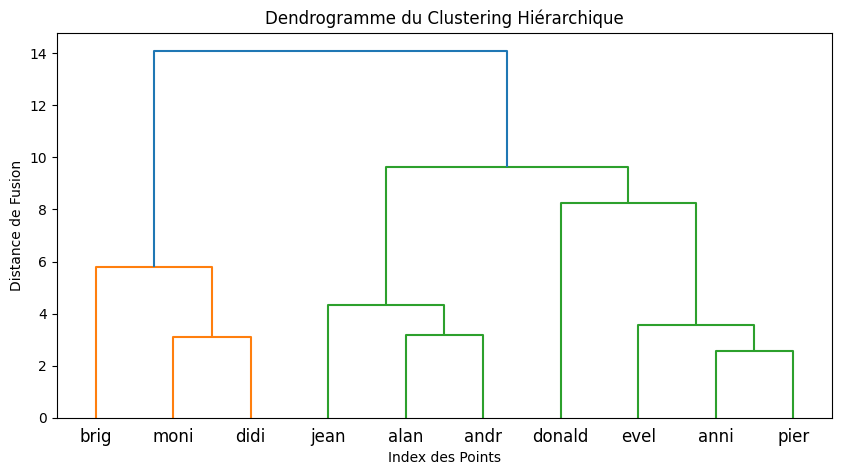

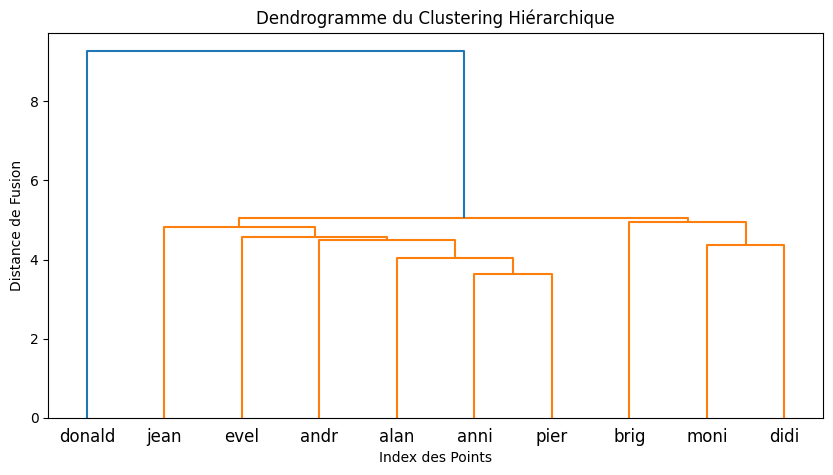

In [66]:
plot_dendrogram(history_Ward, distances_list_Ward, notes.index)
plot_dendrogram(history_ppv, distances_list_ppv, notes.index)   

<b style="color:red">  Réponse : </b> 
 

<b style="color:red">  Réponse (suite): </b>
```


<b style="color:red">  

### Application du clustering hierachique avec scipy <a id="part1sec4"></a>

Maintenant que nous avons compris comment fonctionne la méthode, nous allons changer de jeu de données pour tester l'implementation du clustering hirarchique de ``scipy.cluster.hierarchy``. Pour pouvoir comparer les méthodes, on va générer un jeu de donnée avec le package ``make_blobs``de Python. 

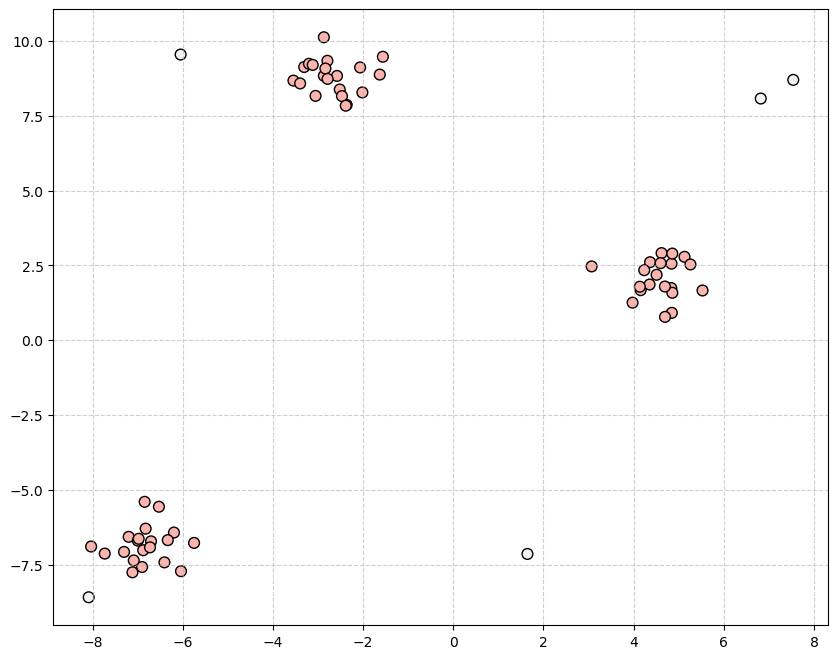

In [35]:
# Génération de données simulées avec des outliers
n=60
X, _ = make_blobs(n_samples=n, centers=3, cluster_std=0.60, random_state=42)
outliers = np.random.uniform(low=-10, high=10, size=(5, 2))  # Ajout de points d'outliers
X = np.vstack([X, outliers])

# Visualisation des clusters détectés
sns.set_palette("pastel")
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c= [0]*n + [1]*5 , cmap='Pastel1', s=60, edgecolor='k')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

<b style="color:red">  À vous de jouer: </b> Consultez la documentation des fonctions **linkage** et **dendrogram** du package ``scipy.cluster.hierarchy`` et lancez un clustering hiérarchique pour différentes méthodes (distances entre les ensembles). Comparez les résultats et choisissez un groupe à conserver. Justifiez.  


<b style="color:red">  Réponse: </b>



<b style="color:red">  Réponse (suite) : </b> L'analyse dépendra du sampling des données. 

## La méthode du K-means <a id="part2"></a>

Pour une fois, nous n'allons pas réimplémenter la méthode K-means nous-mêmes, mais plutôt utiliser l'implémentation disponible sur ``scikitlearn`` et essayer de comprendre l'impact des variables que nous choisissons. Pour ce faire, nous allons commencer par reproduire quelques exemples du cours, en utilisant le jeu de données **george.mat** que nous chargerons ci-dessous. Ensuite, pour illustrer la versatilité de la méthode, nous l'appliquerons à un problème de segmentation d'images. 

### Première utilisation du K-means et selection du K <a id="part2sec1"></a>

Chargeons d'abord le jeu de données 2d **george.mat**, et traçons ce jeu de données sous la forme d'un nuage de points.  

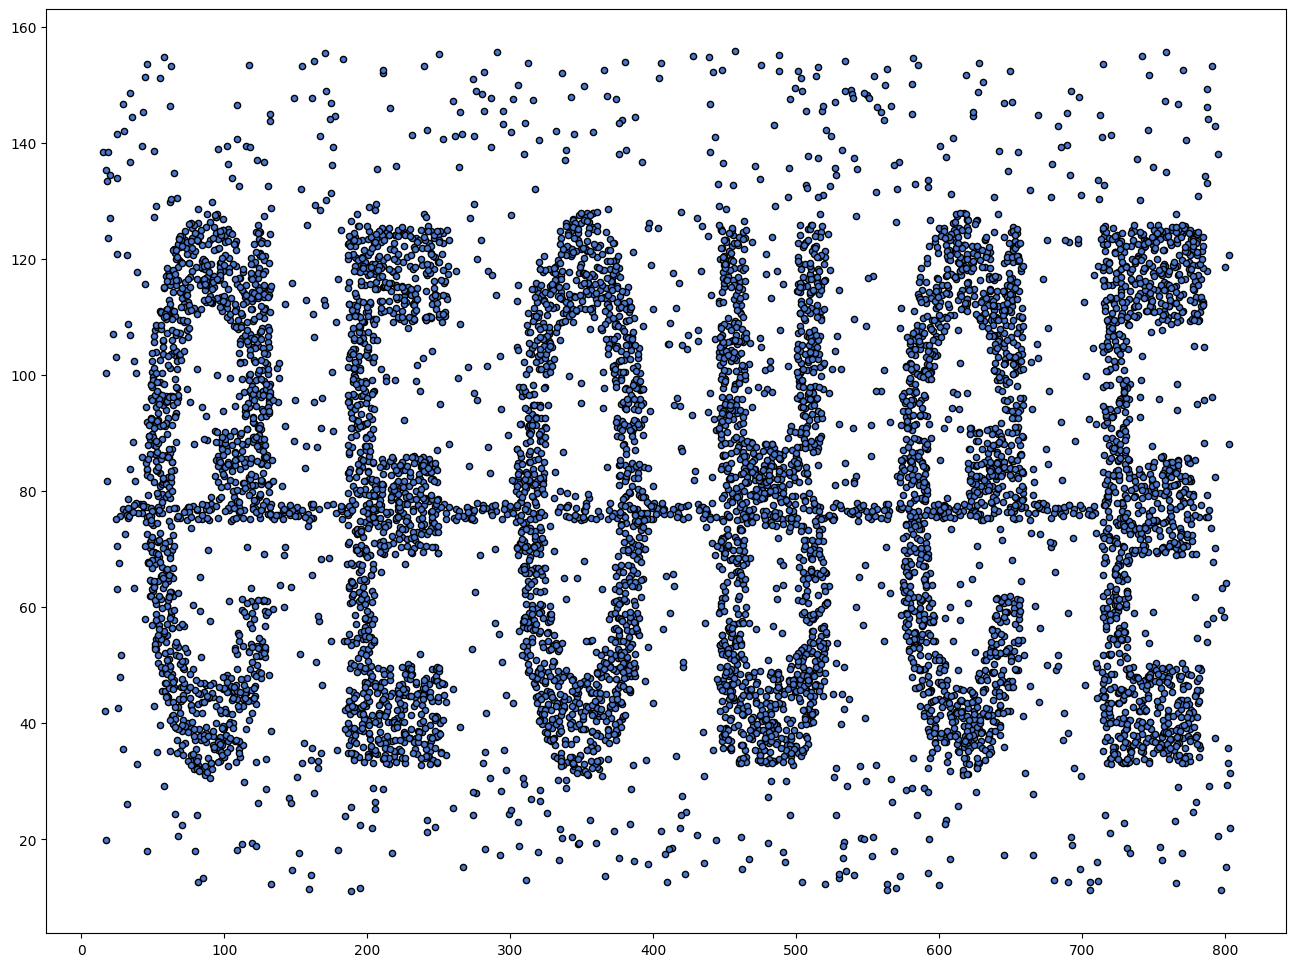

In [3]:
X = sio.loadmat("./george.mat")["george"]

sns.set_palette("muted")
plt.figure(figsize=(16,12))
plt.scatter(X[:,0], X[:, 1],  s=20,  edgecolor='k')
plt.show()

<b style="color:red">  À vous de jouer: </b> Que pouvons nous remarquer par rapport au jeu de données du cours? Comment pouvons nous y remedier. Modifiez La matrice **X** pour remettre les choses en ordre. 

<b style="color:red">  Réponse: </b>  



<b style="color:red">  À vous de jouer: </b> Allez lire la documentation du package **K-means** de ``scikitlearn`` [ici](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans). 

- Quelle initialisation est utilisé par défaut dans cette implementation du K-means ? 
- En vous inspirant de l'exemple, faites un clustering du jeu de données en posant $K=2$. Représentez graphiquement votre résultat. Changez le nombre de cluster deux fois et comparez vos résultats. 

<b style="color:red">  Réponse: </b>



#### Choix de $K$

Notre objectif est de sélectionner le « nombre optimal » de clusters $K$. Pour ce faire, nous allons dans un premier temps utiliser la "technique du coude".

<b style="color:red">  À vous de jouer: </b>  En utilisant toujours le package **Kmeans**, tracez la courbe de l'inertie intra-cluster de votre méthode pour $K$ allant de $2$ à $15$. 

<b style="color:red">   Réponse: </b> 



#### Le coefficient de silhouette

Pour finir, on va se pencher sur une méthode alternative de séléction du nombre de clusters $K$, appelé le coefficient de silhouette. Pour chaque point $z_i$ du jeu de donnée, le coefficient de silhouette associé à $z_i$ est la différence entre la distance moyenne entre $z_i$ avec les points du cluster auxquel il est associé (cohésion) et la distance moyenne de $z_i$ avec les points des autres groupes voisins (séparation). Plus formellement, soit un jeu de données $\mathbf{Z}:=(z_1, \dots , z_n)^T$, une distance de référence $\text{dist}$, et un clustering $C_1, \dots C_K$ pour lequel $z_i \in C_j$ on a 
$$  \text{Silhouette}_{z_i} := \frac{1}{\vert C_j \vert -1 } \sum_{z \in C_j} \text{dist}(z_i, z) - \frac{1}{n- \vert C_j \vert +1} \sum_{z \notin C_j} \text{dist}(z_i, z). $$
Si cette différence est négative, le point est en moyenne plus proche du groupe voisin que du sien, il est donc mal classé. À l'inverse, si cette différence est positive, le point est en moyenne plus proche de son groupe que du groupe voisin, il est donc bien classé. Le coefficient de silhouette du clustering, noté $\text{Silhouette}:= \frac{1}{n} \sum_{i \in [n]} \text{Silhouette}_{z_i}$, est simplement la moyenne des coefficient de silhouette pour tous les points (potentiellement renormalisé). Plus le coefficient de Silhouette est élevé, meilleur est le regroupement. 

<b style="color:red">  À vous de jouer: </b>  En utilisant toujours le package **Kmeans**, tracez la courbe du coefficient de silhouette de votre méthode pour $K$ allant de $2$ à $15$. Commentez. 

<b style="color:red">   Réponse: </b> 



## Application à la ségmentation d'image <a id="part2sec2"></a>

Nous considérons l'image **seaforest_small.jpeg**. Chaque pixel est représenté par ses valeurs RVB. L'objectif est de segmenter cette image en zones homogènes en regroupant ces pixels dans « l'espace couleur ». Pour ce faire, contrairement à ce que nous avons fait dans le TP sur l'analyse en composantes principales (où chaque image représentait un individu), nous allons considérer chaque pixel RVB comme un individu, et nous allons essayer de regrouper les individus (et donc les pixels) entre eux. commencons par télécharger l'mage que nous voulons segementer et affichons la. 

Les dimensions de l'image sont 627 pixels lignes, 837 pixels colonnes, et 3 valeurs RVB par pixel


Text(0.5, 1.0, 'Image originale')

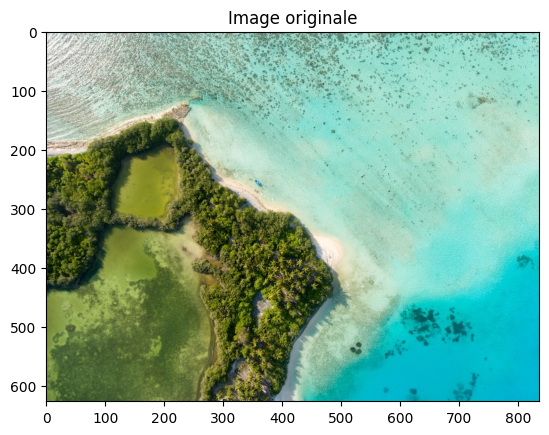

In [4]:
I = plt.imread("seaforest_small.jpeg")
n, m, d = I.shape
print("Les dimensions de l'image sont {} pixels lignes, {} pixels colonnes, et {} valeurs RVB par pixel".format(n, m, d))

plt.imshow(np.uint8(I));
plt.title("Image originale")

Avant d'essayer de segmenter l'image, nous allons changer la représentation de l'image en la transformant en une matrice de nombres de pixels dans l'image $\times$ taille nombre de valeurs par pixel. Cela nous permettra de traiter notre image comme un ensemble de données, où les pixels sont les individus et les valeurs RVB sont les variables. Pour ce faire, on va executer le code ci-dessous. 

In [5]:
X = np.reshape(I, (n*m, d))

<b style="color:red">  À vous de jouer: </b> Exécuter un algorithme Kmeans sur la matrice **X** pour la valeure de $K$ que vous voulez et récupérer les centres finaux de l'algorithme dans une matrice numpy nommée **centres** et les affectations dans un vecteur numpy nommé **y**.

<b style="color:red">  Réponse : </b> 



Pour visualiser l'image après segmentation, on va devoir assigner une nouvelle couleur à chaqu'un des pixels comme nous le faisons habituellement. On peut le faire comme on en a l'habitude, c'est à dire associer une couleur arbitraire à chaque cluster. Mais ici on peut faire mieux que cela. En effet, on peut noter que la valeur des centres, par definition, est la moyenne des valeurs à l'interieur du cluster. On a donc une bonne chance que la valeur du pixel moyen dans chaque cluster soit une bonne représentation de la “couleur moyenne” du cluster. On va construire une nouvelle matrice **Xseg** qui a autant de lignes que **X** et qui remplace chaque pixel de **X** par la valeur du centre du cluster auquel il a été associé. 

<b style="color:red"> À vous de jouer: </b> Vous trouverez ci-dessous le code à trous qui permet de construire **Xseg** puis de visualiser l'image avant et après segmentation. Les trous sont identifiés par la commande ``___hole___``. Remplissez les trous et effectuez la comparaison pour différentes valeurs de $K$. Commentez. 

In [75]:
num_pixels = X.shape[0] #nombres de lignes de X
num_variables = X.shape[1] #nombres de colonnes de X

Xseg = np.zeros((num_pixels,num_variables)) # Initilisation de Xseg

for idx in range(___hole___): 
    Xseg[___hole___]= centers[___hole___]

plt.figure(figsize=(18,10))
plt.subplot(121); plt.imshow(np.uint8(I));
plt.title("Image originale")
plt.subplot(122); plt.imshow(np.uint8(Xseg.reshape(n, m, d)));
plt.title("Image après ségmentation")

NameError: name '___hole___' is not defined

<b style="color:red"> Réponse possible: </b>

N'hésitez pas à utiliser des petite (K=2-3) et des grande (K=100) valeurs de K pour comparer



# Quelques exercices <a id="part3"></a>

## Exercice 1 <a id="part3sec1"></a>

Nous allons utiliser un dataset contenant les statistiques des joueurs de la NBA.  
Vous pouvez le télécharger sur Kaggle : [NBA Players Stats - Saison 2023](https://www.kaggle.com/datasets)  

- Importez le dataset, faites une analyse descripitve rapide et gérez les valeurs manquantes si nécessaire.
- Normalisez les variables pour éviter qu’une caractéristique domine les autres.
- Trouver le nombre optimal de clusters (méthode du coude ou silhouette).
- Appliquer l’algorithme K-Means, et visualisez le resultat (ou pourra utiliser une ACP)
- Décrire les groupes trouvés (ex : joueurs scorers, passeurs, pivots dominants…), et comparez les clusters aux postes des joueurs(gardes, ailiers, pivots).
- Appliquez les mêmes étapes, mais en applicant l'ACP avant le clustering. Commentezd

## Exercice 2 <a id="part3sec2"></a>

Nous allons utiliser un dataset contenant des indicateurs économiques des pays de différents pays : [World Bank Data - Indicateurs économiques](https://data.worldbank.org/). Vous pouvez aussi trouver un dataset similaire sur Kaggle : "World Economic Indicators Dataset".

- Importez le dataset, faites une analyse descripitve rapide et gérez les valeurs manquantes si nécessaire.
- Doit-on normaliser les données ? Si oui faites l'opération.
- Sélectionnez les variables qui vous semblent pertinentes (e.g., PIB, taux de chômage, IDH, dette publique).
- Calculerz une matrice de distance entre les pays en utilisant la distance qui vous semble la plus appropriée.
- Appliquez un clustering hierachique et visualiez le dendrogramme pour déterminer le nombre de clusters.
- Décrire les groupes obtenus (pays riches, émergents, en développement) et comparez les avec des groupes économiques existants (G7, BRICS, pays en développement).
- Comparez le clustering hiérarchique avec K-Means sur le même dataset. Commentez.